# Task

### Pre-defined Code

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

Mounted at /content/drive


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


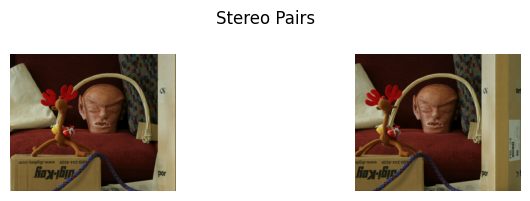

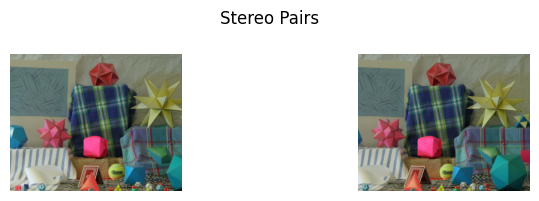

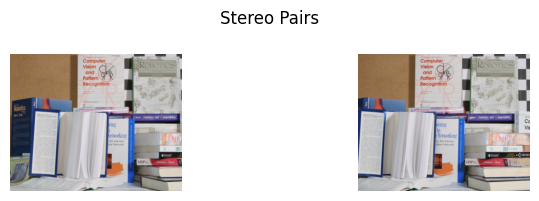

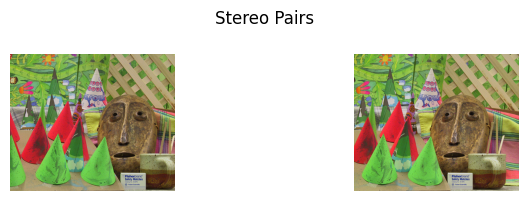

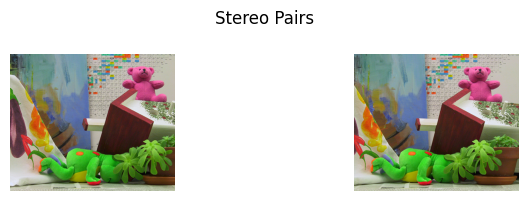

In [ ]:
# Loading all the images in the drive
pair_images = []

paths = natsorted(glob('/content/drive/My Drive/ES666CV/videos/E/*'))

for idx in tqdm(range(0, len(paths), 2)):
    pair_images.append(np.array([cv2.imread(paths[idx], 1), cv2.imread(paths[idx+1], 1)]))

for pairs in pair_images:
    show_image_grid(pairs, 1, 2, 'Stereo Pairs', figsize=8)

### Reconstruction Algorithm

1. [Reconstruction](https://www.cs.cmu.edu/~16385/s15/lectures/Lecture19.pdf) [Must Read]

2. [Stereo and Disparity](https://johnwlambert.github.io/stereo/)

3. [Stereo and 3D Vision](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect16.pdf)

4. [Stereo Reconstruction](https://cs.nyu.edu/~fergus/teaching/vision/9_10_Stereo.pdf)

5. [Epipolar Geometry and the Fundamental Matrix](https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook1/HZepipolar.pdf)

### Q1: Matching Points [2 Marks]

Find the matching points between image pair. You can use OpenCV SIFT feature matching. Plot the matching points over the image.

In [ ]:
def build_matching_point_pairs(image_a, image_b):

    sift = cv2.SIFT_create()

    keypoints_a, descriptors_a = sift.detectAndCompute(image_a, None)
    keypoints_b, descriptors_b = sift.detectAndCompute(image_b, None)

    # Use BFMatcher to match descriptors
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors_a, descriptors_b)

    # Sort matches by distance (best matches first)
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract matching points from keypoints
    matching_point_pair_lst = [
        [keypoints_a[m.queryIdx].pt for m in matches],  # Points from image_a
        [keypoints_b[m.trainIdx].pt for m in matches]  # Points from image_b
    ]

    return matching_point_pair_lst

def plot_matching_points(image_a, image_b, matching_point_pair_lst):

    keypoints_a = [cv2.KeyPoint(x=pt[0], y=pt[1], size=1) for pt in matching_point_pair_lst[0]]
    keypoints_b = [cv2.KeyPoint(x=pt[0], y=pt[1], size=1) for pt in matching_point_pair_lst[1]]

    # Create dummy matches for visualization (one-to-one mapping)
    matches = [cv2.DMatch(i, i, 0) for i in range(len(keypoints_a))]

    # Draw 200 matches
    matched_image = cv2.drawMatches(image_a, keypoints_a, image_b, keypoints_b, matches[:200], None)

    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Matching Points')
    plt.show()


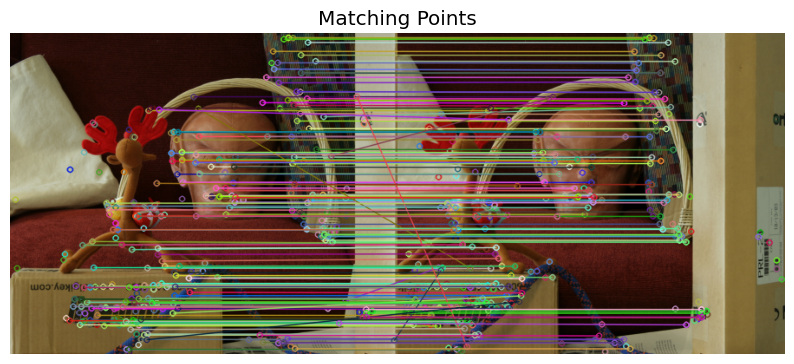

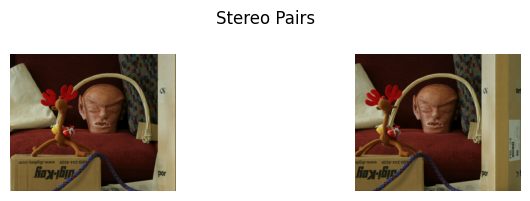

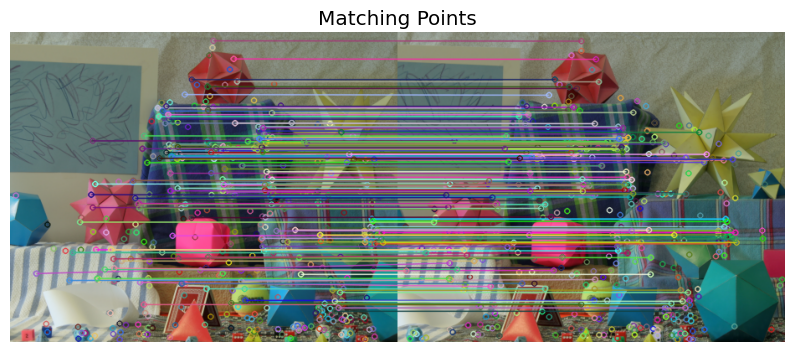

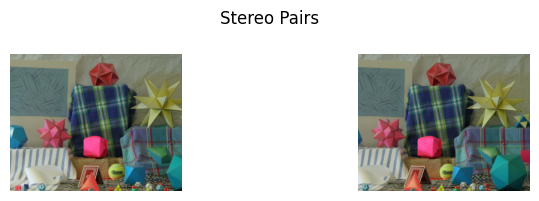

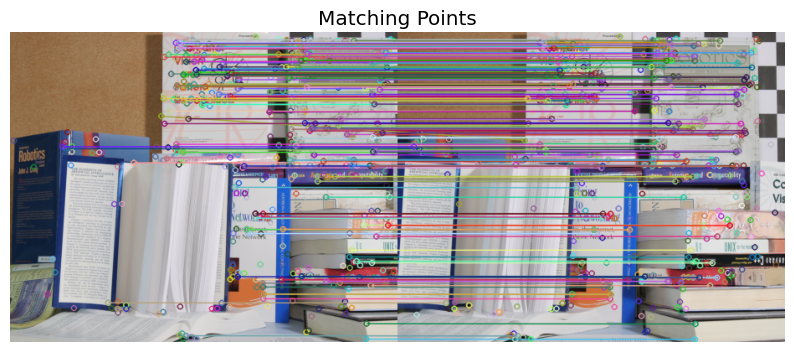

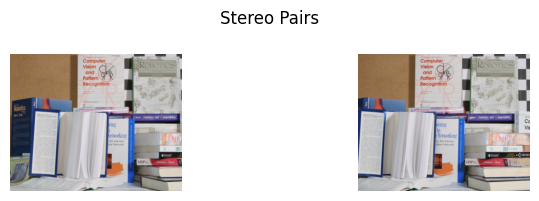

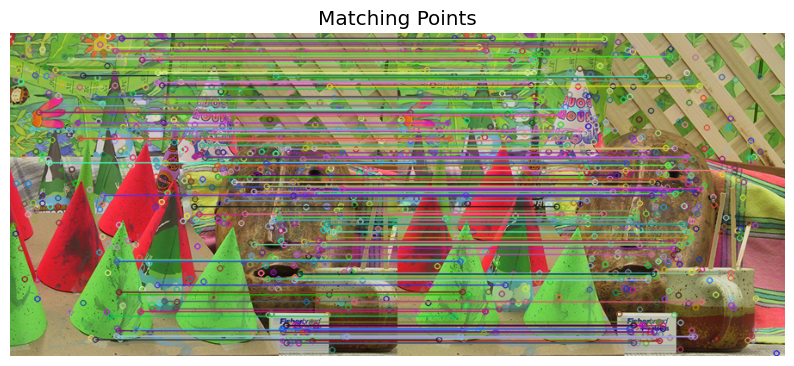

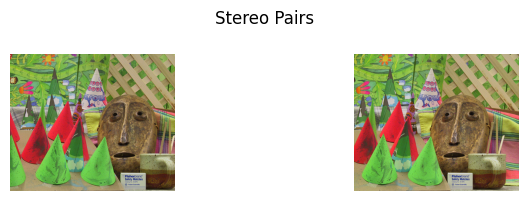

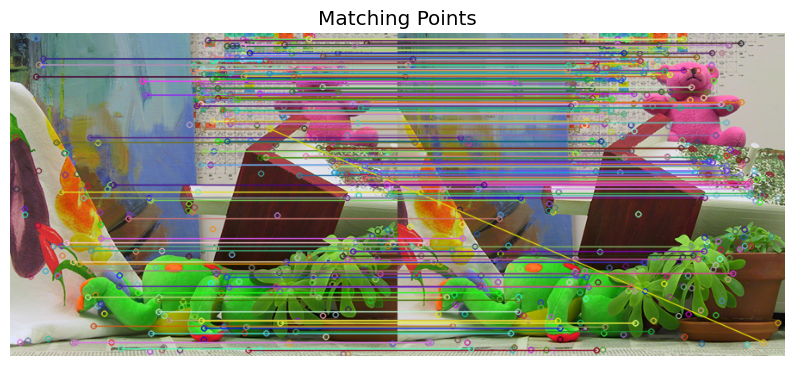

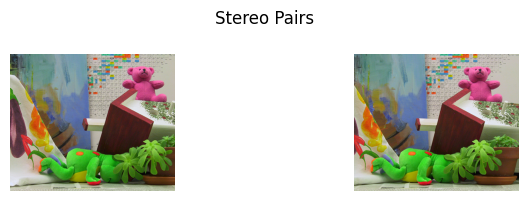

In [ ]:
global_matching_point_pair_lst = []

for pairs in pair_images:

    matching_points = build_matching_point_pairs(pairs[0], pairs[1])
    global_matching_point_pair_lst.append(matching_points)

    # Plot the matching points between the two images
    plot_matching_points(pairs[0], pairs[1], matching_points)

    show_image_grid(np.array(pairs), 1, 2, 'Stereo Pairs', figsize=8)


### Q2: Estimate Camera Matrix [3 Marks]

Estimate the camera matrix [R | t] using matched points, for this question also you are allow to use OpenCV estimate Essential matrix and Camera matrix function.

In [ ]:
def estimate_camera_matrix(matching_point_a, matching_point_b):

    if not matching_point_a or not matching_point_b:
        print("No matching points available.")
        return None

    points_a = np.array(matching_point_a, dtype=np.float32)
    points_b = np.array(matching_point_b, dtype=np.float32)

    # Assume a simple camera intrinsic matrix
    focal_length = 1.0
    principal_point = (0, 0)
    camera_intrinsics = np.array([
        [focal_length, 0, principal_point[0]],
        [0, focal_length, principal_point[1]],
        [0, 0, 1]
    ], dtype=np.float64)

    # Estimate the essential matrix
    essential_matrix, _ = cv2.findEssentialMat(points_a, points_b, camera_intrinsics, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    # Recover the pose (R, t) from the essential matrix
    _, R, t, _ = cv2.recoverPose(essential_matrix, points_a, points_b, camera_intrinsics)

    camera_matrix = np.hstack((R, t))
    return camera_matrix


In [ ]:
global_camera_matrix_lst = []

for matching_point_pair in global_matching_point_pair_lst:
    global_camera_matrix_lst.append(estimate_camera_matrix(matching_point_pair[0], matching_point_pair[1]))

### Q3: Stereo Rectification [2.5 Marks]

You have to perform stereo rectification based on the estimated camera matrix. This will help is algining the image pair which in turn help estimate disparity map easily.

Note: Implement it from scratch no use of OpenCV function is allowed for this part of the algorithm other than warping function if needed.

In [ ]:
def perform_stereo_rectification(image_a, image_b, matching_point_a, matching_point_b, camera_matrix):

    points_a = np.array(matching_point_a, dtype=np.float64)
    points_b = np.array(matching_point_b, dtype=np.float64)

    R = camera_matrix[:, :3]  # Rotation matrix
    t = camera_matrix[:, 3]   # Translation vector

    # Compute optical centers for both cameras
    centre_1 = np.zeros((3, 1))                # Camera 1 center at origin
    centre_2 = -np.dot(R.T, t.reshape(-1, 1))  # Camera 2 center from rotation and translation

    # Compute the baseline vector between camera centers
    baseline = (centre_2 - centre_1).flatten()
    baseline /= np.linalg.norm(baseline)  # Normalize baseline vector

    # Create a new orthogonal coordinate system
    z_axis = np.array([0, 0, 1])          # Reference z-axis
    y_axis = np.cross(z_axis, baseline)   # Compute perpendicular vector to z and baseline
    y_axis /= np.linalg.norm(y_axis)      # Normalize
    x_axis = np.cross(baseline, y_axis)   # Compute third orthogonal vector

    # Rectification rotation matrix
    R_rect = np.array([baseline, y_axis, x_axis])

    # Compute homographies for rectification
    H1 = np.dot(R_rect, np.eye(3))  # Homography for left image
    H2 = np.dot(R_rect, R)          # Homography for right image

    # Determine the dimensions of the images
    h, w = image_a.shape[:2]

    # Rectify the images using the computed homographies
    rectified_image_a = cv2.warpPerspective(image_a, H1, (w, h))
    rectified_image_b = cv2.warpPerspective(image_b, H2, (w, h))

    return [rectified_image_a, rectified_image_b]


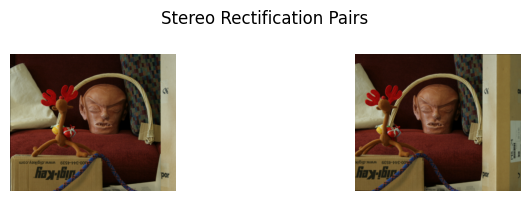

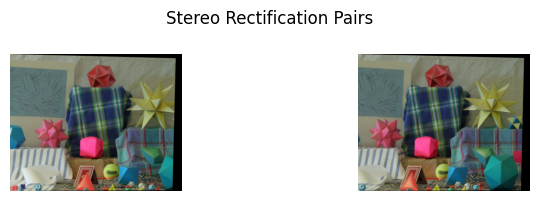

In [ ]:
N = len(pair_images) // 2 # Total stereo image pairs
rectified_pairs = []

for pair_idx in range(N):
    algined_pairs = perform_stereo_rectification(pair_images[pair_idx][0], pair_images[pair_idx][1],\
                                 global_matching_point_pair_lst[pair_idx][0], global_matching_point_pair_lst[pair_idx][1],\
                                 global_camera_matrix_lst[pair_idx])

    rectified_pairs.append(np.array(algined_pairs))
    show_image_grid(rectified_pairs[-1], 1, 2, 'Stereo Rectification Pairs', figsize=8)

### Q4: Disparity Maps [2.5 Marks]

With the help of stereo rectification images, now have to obtain the disparity maps for each pair. No opencv functions are allowed for this algorithm. For convolution you can use scipy or opencv convolution.

In [ ]:
from scipy.signal import convolve2d

def disparity_map(image_a, image_b, block_size=9, disparity_range=32):

    height, width = image_a.shape
    disparity_map = np.zeros((height, width), dtype=np.float32)

    half_window = block_size // 2

    for y in range(half_window, height - half_window):
        for x in range(half_window, width - half_window):
            min_sad = float('inf')
            best_disparity = 0

            # Extract the patch from the left image (search window)
            left_patch = image_a[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1]

            # Check all possible disparities for the corresponding pixel in the right image
            for d in range(0, disparity_range):
                if x - d - half_window >= 0:
                    right_patch = image_b[y - half_window:y + half_window + 1, x - d - half_window:x - d + half_window + 1]

                    sad = np.sum(np.abs(left_patch - right_patch))

                    if sad < min_sad:
                        min_sad = sad
                        best_disparity = d

            disparity_map[y, x] = best_disparity

    disparity_map = (disparity_map / disparity_range) * 255.0
    disparity_map = disparity_map.astype(np.uint8)

    return disparity_map


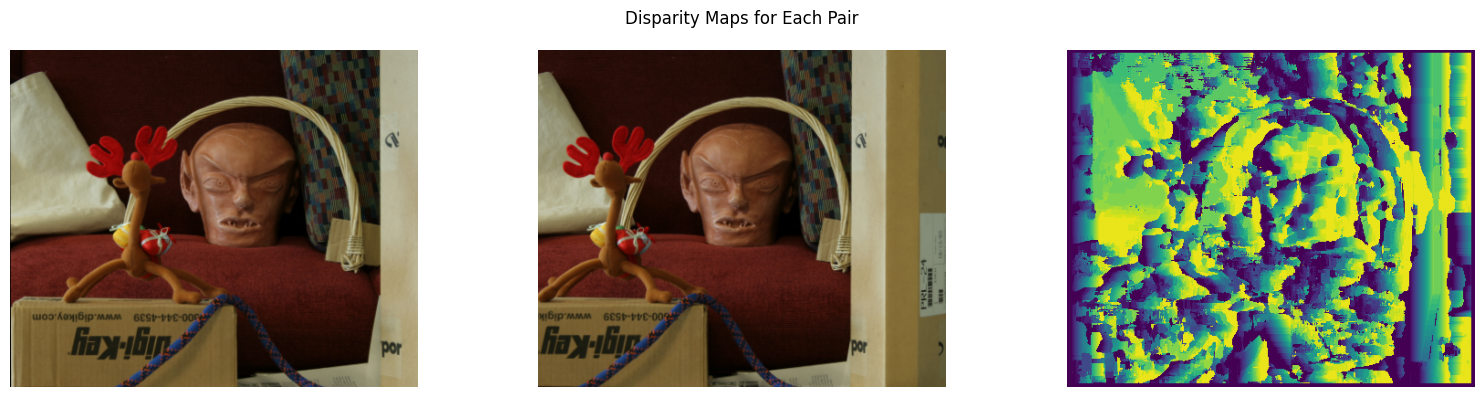

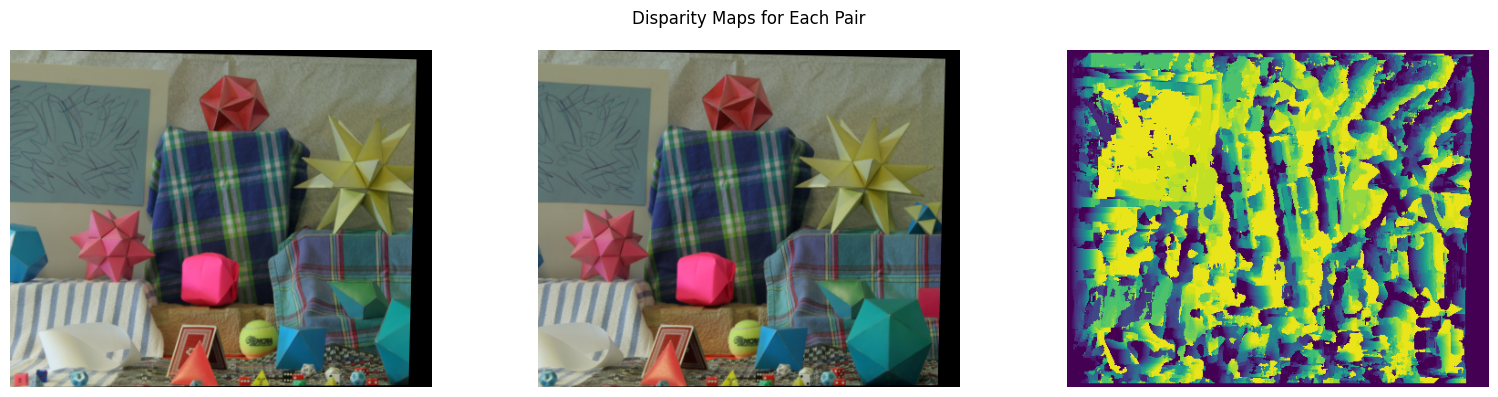

In [ ]:
for pairs in rectified_pairs:
    gray_a = cv2.cvtColor(pairs[0], cv2.COLOR_BGR2GRAY)
    gray_b = cv2.cvtColor(pairs[1], cv2.COLOR_BGR2GRAY)
    disp_map = disparity_map(gray_a, gray_b)

    disp_map_colored = cv2.applyColorMap(disp_map, cv2.COLORMAP_VIRIDIS)
    show_image_grid(np.array([pairs[0], pairs[1], disp_map_colored]), 1, 3, 'Disparity Maps for Each Pair', figsize=16)
